In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import sys
import glob
import sys
import scipy.optimize

import os
import pickle
import tqdm

import shield_optimization as so

In module 'Darwin':
/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/libkern/arm/OSByteOrder.h:14:1: error: '_OSSwapInt16' has different definitions in different modules; definition in module 'Darwin.libkern.OSByteOrder' first difference is return type is 'uint16_t' (aka 'unsigned short')
uint16_t
^~~~~~~~
/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/libkern/arm/_OSByteOrder.h:49:1: note: but in 'DarwinFoundation.OSByteOrder' found different return type '__uint16_t' (aka 'unsigned short')
__uint16_t
^~~~~~~~~~
In module 'Darwin':
/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/libkern/arm/OSByteOrder.h:24:1: error: '_OSSwapInt32' has different definitions in different modules; definition in module 'Darwin.libkern.OSByteOrder' first difference is return type is 'uint32_t' (aka 'unsigned int')
uint32_t
^~~~~~~~


Welcome to JupyROOT 6.30/04


In [2]:
plt.style.use('tableau-colorblind10')
plt.style.use('../figures/style.mplstyle')

In [3]:
E_tot = 8.4736 # MeV
M = (29*931.5 - 21.895) # mass of Si29 (MeV)
E1 = -M + np.sqrt(M**2 + 2*M*E_tot)
E1_lm = E1**2/2/M
hm = ('highmass1', 'highmass2')
lm = 'lowmass'
detectors = ('highmass1', 'highmass2', 'lowmass')

In [4]:
def identify_deposit(PName):
    if PName in 'e- e+ gamma proton alpha deuteron triton':
        return 0
    elif PName in 'P31 ' or PName[:2] in 'Si Al Mg Ge Ga As Se Zn': 
        return 1
    else:
        raise Exception('unknown PName = ' + PName)


def yLind(Er):
    Er *= 1e3 # convert to keV from MeV
    Z = 28
    k = 0.15
    eps = 11.5*Er/np.cbrt(Z)**7
    g = 3*eps**0.15 + 0.7*eps**0.6 + eps
    Y = k*g/(1+k*g) # yield
    return Y 


def get_charge_histograms(rates, Ebins = None, Emin = 100e-6, Emax = 20, Nbins = 200, E_window = 0.1):
    # collect histograms of charge energy in hm1 and hm2, as well as histograms of charge energy in hm1 and hm2 WITH COINCIDENCES WITH lowmass
    # E_window = relative window for energies in lowmass detector to cut by (relative to signal peak = 8.4736 MeV)

    XR = -1
    ER = 0
    NR = 1

    Elow = (1-E_window)*E1_lm
    Ehigh = (1+E_window)*E1_lm
    # bounds of energy window in lowmass detector

    if Ebins == None:
        Ebins = np.linspace(Emin, Emax, Nbins+1, endpoint = True) # bin edges (MeV)
    else:
        Emin = Ebins[0]
        Emax = Ebins[-1]
        Nbins = Ebins.size - 1


    ROOT.TH1.AddDirectory(False)


    events = {meas: {det: ROOT.TH1D(
            det + '_all',
            det + ' all',
            Nbins, Ebins
            ) for det in detectors} for meas in rates.measurements_list}
    
    coincs = {meas: {det: ROOT.TH1D(
            det + '_coinc',
            det + ' coincidence events',
            Nbins, Ebins
            ) for det in hm} for meas in rates.measurements_list}

    ecut = {meas: {det: ROOT.TH1D(
            det + '_coinc_energy_cut',
            det + ' coincidence events w/ energy cut',
            Nbins, Ebins
            ) for det in hm} for meas in rates.measurements_list}

    
    caps = {meas: {det: ROOT.TH1D(
            det + '_captures',
            det + ' postcapture events',
            Nbins, Ebins
            ) for det in hm} for meas in rates.measurements_list}


    if Nbins == 1:
        lm_evts_list = {det: [] for det in hm}
    
    for meas in rates.measurements_list:
        for det in hm:
            events[meas][det].Reset()
            coincs[meas][det].Reset()
            ecut[meas][det].Reset()
            caps[meas][det].Reset()


    for i in tqdm.trange(rates.N):

        meas = rates.measurements[i]

        tfile = ROOT.TFile.Open(rates.glob_list[i], 'READ')
        tree = tfile.Get('tree')

        last_event = -1
        energy = {det: 0. for det in detectors}

        for k in range(tree.GetEntries()):
            tree.GetEntry(k)

            EventNum = int(getattr(tree, 'EventNum'))
            #TrkNum = int(getattr(tree, 'TrkNum'))
            Edep = float(getattr(tree, 'Edep'))
            VolName = getattr(tree, 'VolName')
            PName = getattr(tree, 'PName')
            #ProcName = getattr(tree, 'ProcName')
            ParentVol = getattr(tree, 'ParentVol')
            IsCapture = bool(int(getattr(tree, 'IsCapture')))
            #KE = float(getattr(tree, 'KE'))
            #KE3 = float(getattr(tree, 'KE3'))
            #DepProc = getattr(tree, 'DepProc')
            #Time = float(getattr(tree, 'Time'))
            #X = float(getattr(tree, 'X'))
            #Y = float(getattr(tree, 'Y'))
            #Z = float(getattr(tree, 'Z'))

            if abs(EventNum - last_event) > 1e-6: # new event

                last_event = EventNum

                # process previous event
                for det in detectors:
                    if energy[det] > 0:
                        events[meas][det].Fill(energy[det])
                        if det in hm:
                            if energy[lm] > 0:
                                cprev = coincs[meas][det].GetBinContent(1)
                                coincs[meas][det].Fill(energy[det])
                                if energy[lm] > Elow and energy[lm] < Ehigh:
                                    ecut[meas][det].Fill(energy[det])
                                if Nbins == 1:
                                    cnew = coincs[meas][det].GetBinContent(1)
                                    if cnew > cprev:
                                        lm_evts_list[det].append(energy[lm])
                                if IsCapture:
                                    caps[meas][det].Fill(energy[det])

                energy = {det: 0. for det in detectors}


            # accumulate info from this event
            if Edep > 0:
                if VolName == 'lowmass':
                    energy[VolName] += Edep
                else:
                    DT = identify_deposit(PName)
                    if DT == ER:
                        Eq = Edep
                    elif DT == NR:
                        Eq = Edep*yLind(Edep)
                    energy[VolName] += Eq
            
            # end of loop over tree

        tfile.Close()
        # end of loop over files

    # convert ROOT TH1D's into dataframes
    df = {}
    for meas in rates.measurements_list:
        data_dict = {'E': Ebins}
        for dictionary in (events, coincs, ecut, caps):
            for det in dictionary[meas].keys():
                hist = dictionary[meas][det]
                name = hist.GetName()
                cts = np.zeros(Nbins+1)

                for i in range(1, Nbins+1):
                    cts[i-1] = hist.GetBinContent(i)

                data_dict[name] = cts

        df[meas] = pd.DataFrame.from_dict(data_dict)

    # end of function: return dataframe
    if Nbins == 1:
        return df, lm_evts_list
    else:
        return df


def get_all_histograms(rates, lm_cut = None, hm_cut = None, lmlow = 0, lmhigh = 10, hmlow = 0, hmhigh = 10, Nhm = 30, Nlm = 30):
    """
    rates - BackgroundRates object
    lm_cut - size of energy cut window in lowmass
    hm_cut - size of energy cut window in highmass

    function returns the following types of histogram for each detector:
        "all" - all events
        "coincidences" - all events in coincidence with another event in:
            lowmass (for highmass detectors)
            either one of the highmass detectors (for lowmass)
        "energy_cut" - all events in coincidence, where the coincident event is within the cut window for the other detector
    
    over each of the energy bins:
        "full_range" - full range, 200 bins
            100 eV to 20 MeV in highmass
            1 eV to 7 MeV in lowmass
        "cut_window" - range of energy cuts, 40 bins
            E1 +/- hm_cut/2 in highmass
            E1_lm +/- lm_cut/2 in lowmass

    hm:
        "full_range"
        "cut_window"

    lm:
        "full_range"
        "low_energy"
        "cut_window" 
    """

    # recoil types
    XR = -1
    ER = 0
    NR = 1
    E1_hm = E1

    bg_window = 0.1
    meas = (20., 1.)

    lm = 'lowmass'
    hm1 = 'highmass1'
    hm2 = 'highmass2'
    detectors = (lm, hm1, hm2)
    hm = (hm1, hm2)

    # energy bins (MeV)
    Ebins_full_range_hm = np.linspace(100e-6, 20, 200, endpoint = True)
    Ebins_full_range_lm = np.linspace(1e-6, 7, 200, endpoint = True)
    Ebins_low_energy_lm = np.linspace(1e-6, 3e-3, 200, endpoint = True)

    if hm_cut is not None:
        Ebins_cut_window_hm = E1_hm + hm_cut*np.linspace(-0.5, 0.5, 16, endpoint = True)
        lmlow = Ebins_cut_window_lm.min()
        lmhigh = Ebins_cut_window_lm.max()
        hmlow = Ebins_cut_window_hm.min()
        hmhigh = Ebins_cut_window_hm.max()
    else:
        Ebins_cut_window_hm = np.linspace(hmlow, hmhigh, Nhm, endpoint = True)
    
    if lm_cut is not None:
        Ebins_cut_window_lm = E1_lm + lm_cut*np.linspace(-0.5, 0.5, 16, endpoint = True)
        lmlow = Ebins_cut_window_lm.min()
        lmhigh = Ebins_cut_window_lm.max()
        hmlow = Ebins_cut_window_hm.min()
        hmhigh = Ebins_cut_window_hm.max()
    else:
        Ebins_cut_window_lm = np.linspace(lmlow, lmhigh, Nlm, endpoint = True)


    #bin_types = ('full_range', 'cut_window')

    Ebins_dict = {'lowmass': {
                'full_range': Ebins_full_range_lm,
                'low_energy': Ebins_low_energy_lm,
                'cut_window': Ebins_cut_window_lm
            },
            'highmass1': {
                'full_range': Ebins_full_range_hm,
                'cut_window': Ebins_cut_window_hm
            }
    }
    Ebins_dict['highmass2'] = Ebins_dict['highmass1']

    hist_types = ('all', 'coincidences', 'energy_cut')
    all_hists = {}

    ROOT.TH1.AddDirectory(False)

    for hist_type in hist_types:
        all_hists[hist_type] = {}

        for det, bin_dict in Ebins_dict.items():
            all_hists[hist_type][det] = {}
            for bin_type, Ebins in bin_dict.items():
                all_hists[hist_type][det][bin_type] = ROOT.TH1D(
                    '_'.join([det, hist_type, bin_type]),
                    '_'.join([det, hist_type, bin_type]),
                    Ebins.size-1, 
                    Ebins
                )

    
    for hist_type in hist_types:
        for det in detectors:
            for bin_type in Ebins_dict[det]:
                all_hists[hist_type][det][bin_type].Reset()


    for i in tqdm.trange(rates.N):

        measi = rates.measurements[i]

        tfile = ROOT.TFile.Open(rates.glob_list[i], 'READ')
        tree = tfile.Get('tree')

        last_event = -1
        energy = {det: 0. for det in detectors}

        for k in range(tree.GetEntries()):
            tree.GetEntry(k)

            EventNum = int(getattr(tree, 'EventNum'))
            #TrkNum = int(getattr(tree, 'TrkNum'))
            Edep = float(getattr(tree, 'Edep'))
            VolName = getattr(tree, 'VolName')
            PName = getattr(tree, 'PName')
            #ProcName = getattr(tree, 'ProcName')
            ParentVol = getattr(tree, 'ParentVol')
            IsCapture = bool(int(getattr(tree, 'IsCapture')))
            #KE = float(getattr(tree, 'KE'))
            #KE3 = float(getattr(tree, 'KE3'))
            #DepProc = getattr(tree, 'DepProc')
            Time = float(getattr(tree, 'Time'))
            #X = float(getattr(tree, 'X'))
            #Y = float(getattr(tree, 'Y'))
            #Z = float(getattr(tree, 'Z'))

            if abs(EventNum - last_event) > 1e-6: # new event

                # process previous event
                for det in detectors:
                    bintypes = Ebins_dict[det]
                    if energy[det] > 0:
                        for b in bintypes:
                            all_hists['all'][det][b].Fill(energy[det])
                        if det == lm:
                            if (energy[hm1] > 0) or (energy[hm2] > 0):
                                for b in bintypes:
                                    all_hists['coincidences'][det][b].Fill(energy[det])
                                if (energy[hm1] > hmlow and energy[hm1] < hmhigh) or (energy[hm2] > hmlow and energy[hm2] < hmhigh):
                                    for b in bintypes:
                                        all_hists['energy_cut'][det][b].Fill(energy[det])
                                        if energy[lm] > lmlow and energy[lm] < lmhigh:
                                            print(rates.glob_list[i], last_event, det, file = open('ecut_evts.txt', 'a'))
                        else:
                            if energy[lm] > 0:
                                for b in bintypes:
                                    all_hists['coincidences'][det][b].Fill(energy[det])
                                if energy[lm] > lmlow and energy[lm] < lmhigh:
                                    for b in bintypes:
                                        all_hists['energy_cut'][det][b].Fill(energy[det])
                                        
                        

                energy = {det: 0. for det in detectors}
                last_event = EventNum


            # accumulate info from this event
            if (Edep > 0) and (Time < 1e9*360*24*365*100):
                if VolName == lm:
                    energy[VolName] += Edep
                else:
                    DT = identify_deposit(PName)
                    if DT == ER:
                        Eq = Edep
                    elif DT == NR:
                        Eq = Edep*yLind(Edep)
                    energy[VolName] += Eq
            
            # end of loop over tree

        tfile.Close()
        # end of loop over files

    # convert ROOT TH1D's into dataframes

    df_dict = {h: {} for h in hist_types}

    for hist_type in hist_types:
        for det in detectors:
            df_dict[hist_type][det] = {}
            for bin_type in Ebins_dict[det]:
                h = all_hists[hist_type][det][bin_type]
                Ebins = Ebins_dict[det][bin_type]
                Nbins = Ebins.size - 1
                cts = np.zeros(Nbins+1)
                for i in range(1, Nbins+1):
                    cts[i-1] = h.GetBinContent(i)
                

                df_dict[hist_type][det][bin_type] = pd.DataFrame.from_dict({'E': Ebins, 'spec': cts})

    return Ebins_dict, df_dict


class Counts:

    def __init__(self, match, Emin = 0.5e-6, Emax = 10, Nbins = 200, logbins = False, raw_data_dir = '../build/cap_sim/', save = True):

        self.raw_data_dir = raw_data_dir
        self.match = match
        self.Nprimaries = cap_primaries_dict[self.match]
        self.filenames = glob.glob(self.raw_data_dir+self.match)
        self.save = save

        self.Emin = Emin
        self.Emax = Emax
        self.Nbins = Nbins

        self.storage_dir = 'analysis_data/cap_sim_cts/'

        if logbins:
            self.Ebins = np.geomspace(Emin, Emax, Nbins+1, endpoint = False) 
        else:    
            self.Ebins = np.linspace(Emin, Emax, Nbins+1, endpoint = True) # bin edges (MeV)


        if self.save and self.match+'.txt' in os.listdir(self.storage_dir):
            
            with open(self.storage_dir + self.match + '.txt', 'rb') as file:
                self.cts = pickle.load(file)
            #self.cts = np.loadtxt(self.storage_dir + self.match+'.txt')
            self.Ebins = np.loadtxt(self.storage_dir + self.match + '_Ebins.txt')
            self.Nbins = len(self.Ebins)
            Emin = self.Ebins[0]
            Emax = self.Ebins[-1]

            print('loaded ' + self.match+'.txt')
        else:
            print('running get_gamma_deposit_spec()')
            self.cts = get_gamma_deposit_spec(self.filenames, self.Ebins)
            if self.save:
                with open(self.storage_dir + self.match + '.txt', 'wb') as file:
                    pickle.dump(self.cts, file)
                np.savetxt(self.storage_dir + self.match + '_Ebins.txt', self.Ebins)

        self.dE = (self.Ebins[1:] - self.Ebins[:-1]).mean()
        self.Emids = (self.Ebins[1:] + self.Ebins[:-1])/2# bin centers

        self.hm = self.cts['highmass1'] + self.cts['highmass2']

In [5]:
detectors = ('lowmass', 'highmass1', 'highmass2')
hm = ('highmass1', 'highmass2')
lm = 'lowmass'
meas = (20.,1.)

leadrates = so.BackgroundRates(match = 'Lead20.000000_PE1.000000_*_t*.root', Ndefault = 1e8, folder = '../build/rate_data/', verbose = 3, part = 5)
leadrates.pre_analyze()


collecting 1600 files


In [6]:
cap_primaries_dict = {
    'simdata_20250302_113418_t*.root': 100000000.,
}

cap_match = 'simdata_20250302_113418_t*.root'

capcts = Counts(cap_match)

loaded simdata_20250302_113418_t*.root.txt


In [7]:
try:
    capture_rate = leadrates.rates[meas][2,1]
    dcapture_rate = leadrates.drates[meas][2,1]
except:
    capture_rate = 0.9657000000000406 # 522 captures
    dcapture_rate = 0.042267540737546475
capture_rate, dcapture_rate

(0.9657000000000406, 0.042267540737546475)

In [8]:
leadrates.meas_exposures[meas]
# 540.5405405405178 sec

540.5405405405178

In [9]:
idx_E1 = np.where(capcts.Ebins < E1)[0][-1]
rel_postcap_rate = capcts.hm[idx_E1]/capcts.Nprimaries # per capture
drel_postcap_rate = np.sqrt(capcts.hm[idx_E1])/capcts.Nprimaries
signal_rate = rel_postcap_rate*capture_rate # Hz
dsignal_rate1 = rel_postcap_rate*dcapture_rate
dsignal_rate2 = drel_postcap_rate*capture_rate
dsignal_rate = dsignal_rate1 + dsignal_rate2
print(signal_rate, dsignal_rate1, dsignal_rate2)
print(f'rel_postcap_rate = {100*rel_postcap_rate} +/- {100*drel_postcap_rate}%')
print('signal rate =', 1000*signal_rate, '+/-', 1000*dsignal_rate, 'mHz')

0.0005020674300000211 2.1974894429450413e-05 2.2019230621232904e-06
rel_postcap_rate = 0.05199 +/- 0.00022801315751508726%
signal rate = 0.5020674300000211 +/- 0.0241768174915737 mHz


In [10]:
signal_rate*3600*24 # events/day

43.37862595200182

In [11]:
window = 0.01 # size of window (MeV)
Emin = E1 - window
Emax = E1 + window
bins = 80
capmatch2 = 'simdata_20250302_113418_t*root'
cap_primaries_dict[capmatch2] = cap_primaries_dict[cap_match]

capcts2 = Counts(capmatch2, Emin = Emin, Emax = Emax, Nbins = bins, save = True)

loaded simdata_20250302_113418_t*root.txt


In [12]:
exposure = leadrates.meas_exposures[meas]
exposure # seconds

540.5405405405178

In [13]:
print(f'gamma energy {E1} MeV')

gamma energy 8.472270339079842 MeV


In [14]:
print(f'NR energy {E1_lm*1e3} keV')

NR energy 1.329660920468643 keV


In [15]:
hist_types = ('all', 'coincidences', 'energy_cut')
lm_cut = 500e-6 # 500 eV cut window in lowmass
hmlow, hmhigh, Nhm = 7., 10., 32 # cut between 7 and 10 MeV
Ebins_dict, all_hist_dict = get_all_histograms(leadrates, lm_cut = lm_cut, hmlow = hmlow, hmhigh = hmhigh, Nhm = Nhm)

100%|██████████| 1600/1600 [39:51<00:00,  1.49s/it]


In [16]:
all_hist_dict.keys()

dict_keys(['all', 'coincidences', 'energy_cut'])

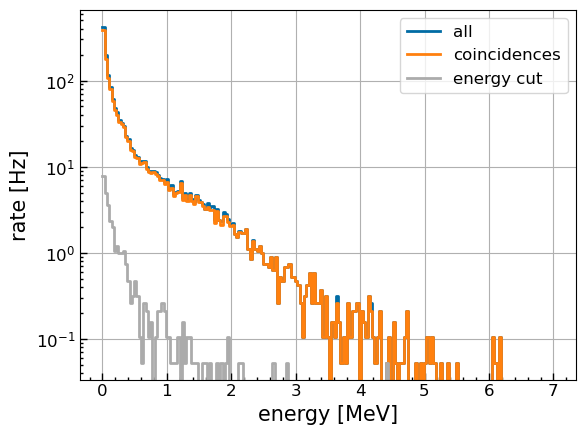

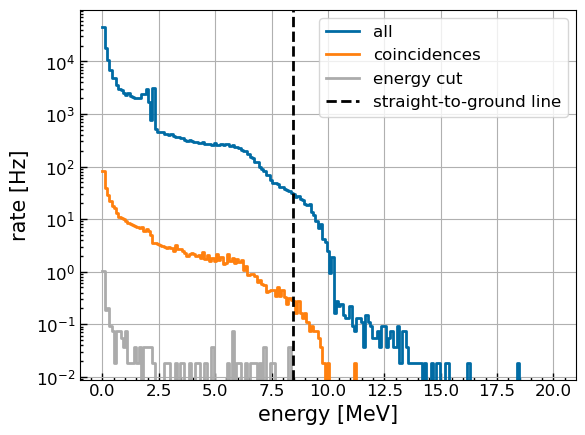

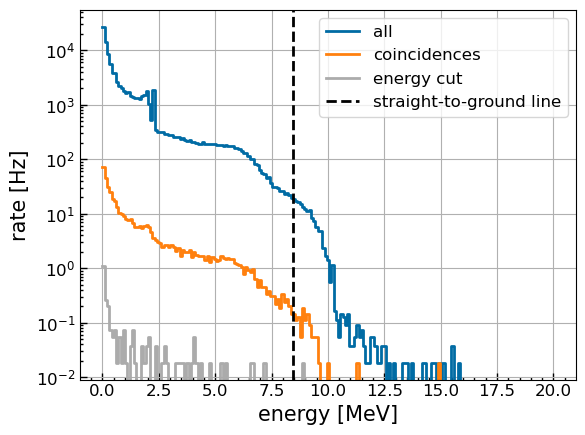

In [17]:
plt.style.use('tableau-colorblind10')
plt.style.use('../figures/style.mplstyle')

# all backgrounds, full range
bin_type = 'full_range'

for det in detectors:

    plt.figure()
    ax = plt.gca()

    #ax.set_title(f'{det} background spectra')

    for h in hist_types:
        #label = ' '.join(c.split('_')[1:]) 
        hist = all_hist_dict[h][det][bin_type]
        #Ebins = hist['E'].values # MeV
        Ebins = Ebins_dict[det][bin_type] # MeV
        dE = (Ebins[1:] - Ebins[:-1]).mean()
        cts = hist['spec'].values
        y = cts/leadrates.meas_exposures[meas]/dE
        #y = df[c].values/leadrates.meas_exposures[meas]
        if h == 'energy_cut':
            h = 'energy cut'
        ax.step(Ebins, y, where = 'post', label = h)
        


    #ax.step(capcts.Ebins, capcts.cts[det]*capture_rate/capcts.Nprimaries, where = 'post', label = 'postcapture')

    if det in hm:
        plt.axvline(E1, linestyle = 'dashed', color = 'k', label = 'straight-to-ground line')

    if det == 'highmass1':
        window1 = ax.axis()
    #elif det == 'lowmass':
    #    ax.set_xlim(-0.01, 3)


    ax.semilogy()
    ax.grid()

    ax.legend()
    ax.set_xlabel('energy [MeV]')
    ax.set_ylabel('rate [Hz]')

In [18]:
Ebins_dict['highmass1']['full_range'][-10:]

array([19.09548191, 19.19598392, 19.29648593, 19.39698794, 19.49748995,
       19.59799196, 19.69849397, 19.79899598, 19.89949799, 20.        ])

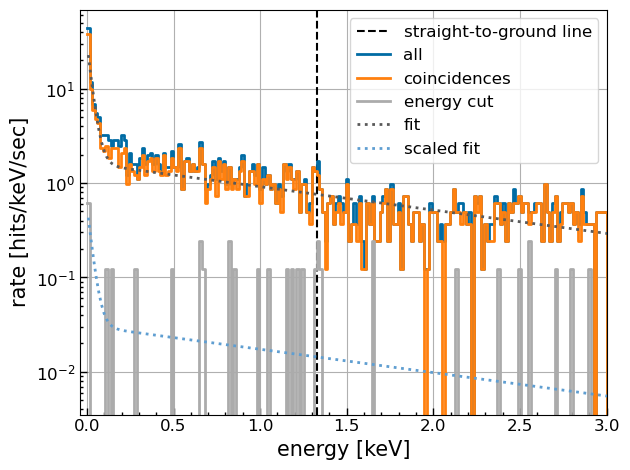

In [ ]:
# spectrum in lm
bin_type = 'low_energy'
det = lm


plt.figure()
ax = plt.gca()
ax.semilogy()
ax.grid()

plt.axvline(E1_lm*1e3, linestyle = 'dashed', color = 'k', label = 'straight-to-ground line', linewidth = 1.5)


#ax.set_title(f'{det} background spectra')

for h in hist_types:
    #label = ' '.join(c.split('_')[1:]) 
    hist = all_hist_dict[h][det][bin_type]
    Ebins = Ebins_dict[lm][bin_type]*1e3 #hist['E'].values*1e3 # keV
    dE = (Ebins[1:] - Ebins[:-1]).mean()
    cts = hist['spec'].values
    y = cts/leadrates.meas_exposures[meas]/dE
    dy = np.sqrt(cts)/leadrates.meas_exposures[meas]/dE
    #y = df[c].values/leadrates.meas_exposures[meas]
    if h == 'energy_cut':
        h = 'energy cut'
    ax.step(Ebins, y, where = 'post', label = h)
    #ax.errorbar(Ebins + dE/2, y, yerr = dy, label = h, linestyle = '', marker = '_', capsize = 2)



# fit orange curve to double exponential
def doubleexp(x, A, a, B, b):
    return A*np.exp(-x/a) + B*np.exp(-x/b)

def lndoubleexp(*args, **kwargs):
    return np.log(doubleexp(*args, **kwargs))

def intdoubleexp(x1, x2, A, a, B, b):
    return A*a*(np.exp(-x1/a) - np.exp(-x2/a)) + B*b*(np.exp(-x1/b) - np.exp(-x2/b))

def tripleexp(x, A, a, B, b, C, c):
    return A*np.exp(-x/a) + B*np.exp(-x/b) + C*np.exp(-x/c)

def lntripleexp(*args, **kwargs):
    return np.log(tripleexp(*args, **kwargs))


Ebins = Ebins_dict[lm]['low_energy']*1e3 # keV
histfit = all_hist_dict['coincidences'][lm]['low_energy']
cts = histfit['spec'].values
y = cts/leadrates.meas_exposures[meas]/dE
dy = np.sqrt(cts)/leadrates.meas_exposures[meas]/dE
x = Ebins + dE/2

guess = np.array([50., 0.01, 2., 0.7])
guess3 = np.concatenate((guess, [0.4, 200]))

popt, pcov = scipy.optimize.curve_fit(lndoubleexp, x[y>0], np.log(y[y>0]), p0 = guess, bounds = (0, np.inf))#, sigma = dy[y>0])
popt3, pcov3 = scipy.optimize.curve_fit(lntripleexp, x[y>0], np.log(y[y>0]), p0 = guess3, bounds = (0, np.inf))#, sigma = dy[y>0])

ax.plot(x, doubleexp(x, *popt), ':', label = 'fit')
#ax.plot(x, tripleexp(x, *popt3), label = 'fit3')

conv_hist_type = 'low_energy'
conv = sum(all_hist_dict['energy_cut'][lm][conv_hist_type]['spec'])/sum(all_hist_dict['coincidences'][lm][conv_hist_type]['spec'])

popt_scaled = popt*np.array([conv, 1., conv, 1.])

wind = plt.axis()

#ax.plot(x, conv*doubleexp(x, *popt), ':', label = 'scaled fit')
ax.plot(x, doubleexp(x, *popt_scaled), ':', label = 'scaled fit')
#ax.plot(x, conv*tripleexp(x, *popt3), label = 'scaled3')

#plt.axis(wind)

ax.set_xlim(-0.04, 3)

np.savetxt('lnpopt.txt', popt_scaled)

ax.legend()
ax.set_xlabel('energy [keV]')
ax.set_ylabel('rate [hits/keV/sec]')

plt.tight_layout()
plt.savefig('../figures/sim_lm_spectra.pdf')

if 0:
    plt.figure()
    plt.semilogy()
    plt.plot(x[y>0], y[y>0], '.')
    #plt.plot(x, doubleexp(x, *guess))
    plt.plot(x, tripleexp(x, *guess3))


In [20]:
for hist_type in ('full_range', 'low_energy', 'cut_window'):
    Ebounds = Ebins_dict[lm][hist_type][[0,-1]]*1e3 # keV
    cts_cut = sum(all_hist_dict['energy_cut'][lm][hist_type]['spec'])/exposure
    cts_coinc = sum(all_hist_dict['coincidences'][lm][hist_type]['spec'])/exposure
    cts_coinc_fit = intdoubleexp(*Ebounds, *popt)
    cts_cut_fit = intdoubleexp(*Ebounds, *popt_scaled)
    print(hist_type)
    #print(Ebounds)
    print('coinc rate', cts_coinc, cts_coinc_fit)
    print('cut rate', cts_cut, cts_cut_fit)
    print('ratio', cts_cut/cts_coinc, cts_cut_fit/cts_coinc_fit) # = 0.0239918

full_range
coinc rate 47.113950000001985 3.5743849411443644
cut rate 1.1303500000000475 0.06780676040111261
ratio 0.023991832567636547 0.01897018970189702
low_energy
coinc rate 3.4132500000001436 3.0609298782647403
cut rate 0.06475000000000272 0.05806642045488668
ratio 0.018970189701897018 0.01897018970189702
cut_window
coinc rate 0.3755500000000158 0.38044619392070683
cut rate 0.014800000000000623 0.007217136470040509
ratio 0.03940886699507389 0.018970189701897018


In [21]:
popt.astype(str)

array(['29.100747121606982', '0.026313791867575275', '1.618097273784256',
       '1.7544101643005299'], dtype='<U32')

In [ ]:
popt_scaled.astype(str) # for printing

array(['0.5520466933638181', '0.026313791867575275',
       '0.030695612239809735', '1.7544101643005299'], dtype='<U32')

In [24]:
for c in ('coincidences', 'energy_cut'):
    print(all_hist_dict[c][lm]['low_energy'].keys())

Index(['E', 'spec'], dtype='object')
Index(['E', 'spec'], dtype='object')


lowmass all 0.9028 +/- 0.0558688 hits/sec/MeV
lowmass coincidences 0.8103 +/- 0.0527169 hits/sec/MeV
lowmass energy_cut 0.0888 +/- 0.0104652 hits/sec/MeV
highmass1 all 33.8414 +/- 0.144419 hits/sec/MeV
highmass1 coincidences 0.275033 +/- 0.0125473 hits/sec/MeV
highmass1 energy_cut 0.0234333 +/- 0.00151052 hits/sec/MeV
highmass2 all 21.6407 +/- 0.115468 hits/sec/MeV
highmass2 coincidences 0.204733 +/- 0.010681 hits/sec/MeV
highmass2 energy_cut 0.0209667 +/- 0.000872098 hits/sec/MeV


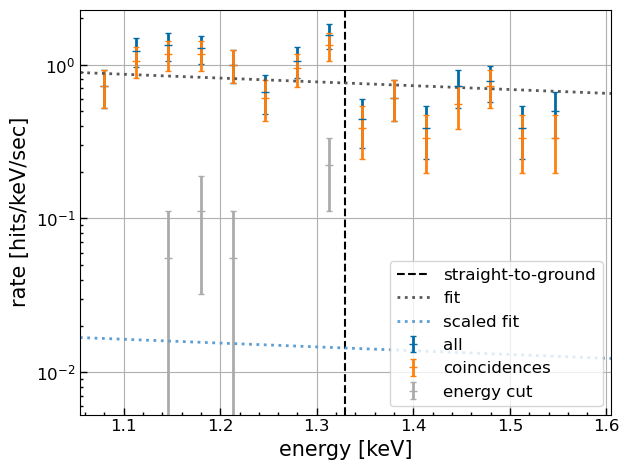

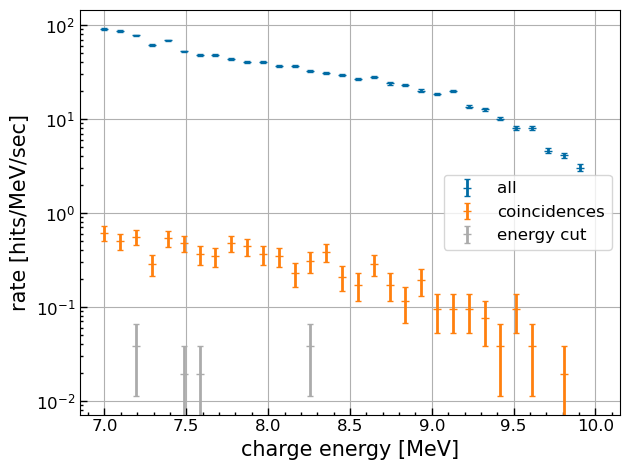

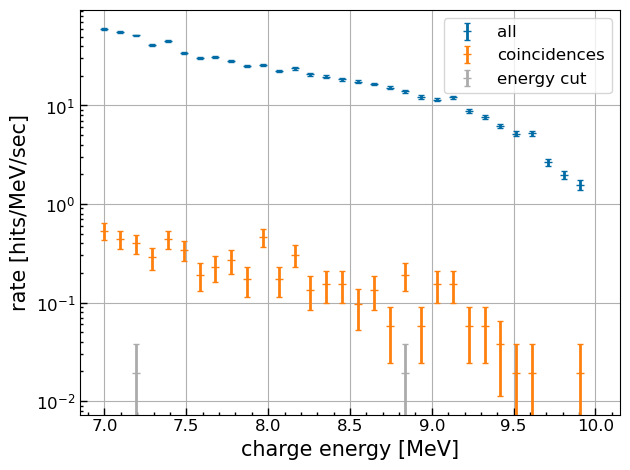

In [74]:
bin_type = 'cut_window'
for det in detectors:

    if det == 'lowmass':
        k = 1e3
        eu = 'keV'
    else:
        k = 1
        eu = 'MeV'


    plt.figure()
    ax = plt.gca()

    #ax.set_title(f'{det} background spectra')
    #Ebins = df4['E'].values
    #dE = (Ebins[1:] - Ebins[:-1]).mean()


    #for c in df4.columns[1:]:
    for h in hist_types:
        hist = all_hist_dict[h][det][bin_type]
        Ebins = hist['E'].values*k
        dE = (Ebins[1:] - Ebins[:-1]).mean()
        cts = hist['spec'].values
        y = cts/leadrates.meas_exposures[meas]/dE
        dy = np.sqrt(cts)/leadrates.meas_exposures[meas]/dE
        lable = h.split('_')[0] + (' cut' if 'energy' in h else '')
        #ax.step(Ebins, y, where = 'post', label = c)
        ax.errorbar(Ebins, y, yerr = dy, label = lable, linestyle = '', marker = '_', capsize = 2)

        print(det, h, f'{(cts+1).sum()/exposure/(Ebins[-1]-Ebins[0]):.6g} +/- {np.sqrt(cts.sum())/exposure/(Ebins[-1]-Ebins[0]):.6g}', 'hits/sec/MeV')

    if 0: # plot expected capture spectrum
        dEcap = np.diff(capcts2.Ebins).mean()
        capy = capcts2.cts[det]*capture_rate/capcts2.Nprimaries/dEcap
        dcapy = np.sqrt(capcts2.cts[det])*capture_rate/capcts2.Nprimaries/dEcap
        
        ax.errorbar(capcts2.Ebins, capy, yerr = dcapy, label = 'postcapture signal', linestyle = '', marker = '_', capsize = 0)

    #plt.axvline(E1, linestyle = 'dashed', color = 'gray', label = 'straight-to-ground')
    if det == 'lowmass':
        ax.axvline(E1_lm*1e3, linestyle = 'dashed', color = 'k', label = 'straight-to-ground', linewidth = 1.5)

    ax.semilogy()
    ax.grid()
    #ax.legend(loc = 'lower right')

    wind = ax.axis()
    if det == lm:
        ax.plot(x, doubleexp(x, *popt), ':', label = 'fit')
        ax.plot(x, doubleexp(x, *popt_scaled), ':', label = 'scaled fit')

        ax.axis(wind)
        ax.set_ylim(wind[2]/5, wind[3])


    
    ax.set_xlabel(('charge ' if det in hm else '') + f'energy [{eu}]')
    ax.set_ylabel(f'rate [hits/{eu}/sec]')
    plt.tight_layout()
    if det == lm:
        ax.legend(loc = 'lower right')
    else:
        ax.legend()

    if det == 'highmass1':
        window2 = ax.axis()
    elif det == 'lowmass':
        plt.savefig('../figures/sim_lm_zoomed_spectra.pdf')


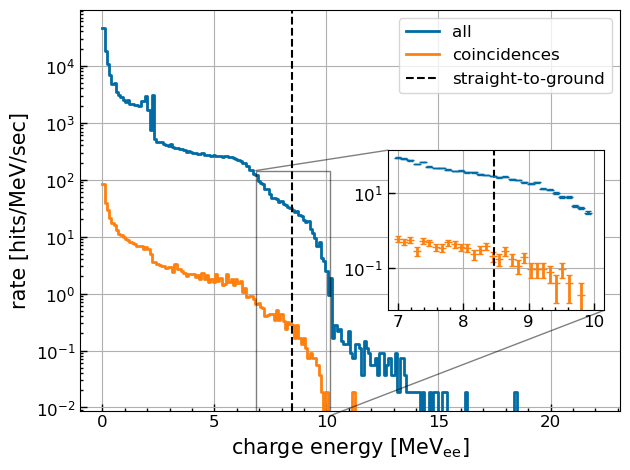

In [26]:
plt.style.use('tableau-colorblind10')
plt.style.use('../figures/style.mplstyle')

# all backgrounds, full range
bin_type = 'full_range'

det = 'highmass1'

fig = plt.figure()
ax = plt.gca()

#ax.set_title(f'{det} background spectra')

for h in ('all', 'coincidences'):
    #label = ' '.join(c.split('_')[1:]) 
    hist = all_hist_dict[h][det][bin_type]
    Ebins = hist['E'].values
    dE = (Ebins[1:] - Ebins[:-1])
    cts = hist['spec'].values
    y = cts/leadrates.meas_exposures[meas]
    y[:-1] /= dE
    #y = df[c].values/leadrates.meas_exposures[meas]
    if h == 'energy_cut':
        h = 'energy cut'
    ax.step(Ebins, y, where = 'post', label = h)


#ax.step(capcts.Ebins, capcts.cts[det]*capture_rate/capcts.Nprimaries, where = 'post', label = 'postcapture')

plt.axvline(E1, linestyle = 'dashed', color = 'k', label = 'straight-to-ground', linewidth = 1.5)


ax.semilogy()
ax.grid()
window = ax.axis()
ax.set_xlim(window1[0], 1.1*window1[1])

ax.legend()
ax.set_xlabel(r'charge energy [MeV$_{\text{ee}}$]')
ax.set_ylabel('rate [hits/MeV/sec]')

Ebins_cut = all_hist_dict['energy_cut'][det]['cut_window']['E'].values

ax2 = ax.inset_axes([0.57, 0.25, 0.4, 0.4], xlim = (window2[0], window2[1]), ylim = (window2[2], window2[3]))


for h in ('all', 'coincidences'):
    hist = all_hist_dict[h][det]['cut_window']
    Ebins = hist['E'].values
    dE = (Ebins[1:] - Ebins[:-1]).mean()
    cts = hist['spec'].values
    y = cts/leadrates.meas_exposures[meas]/dE
    dy = np.sqrt(cts)/leadrates.meas_exposures[meas]/dE
    lable = h.split('_')[0] + (' cut' if 'energy' in h else '')
    #ax2.step(Ebins, y, where = 'post', label = c)
    ax2.errorbar(Ebins, y, yerr = dy, label = lable, linestyle = '', marker = '_', capsize = 2)

    #print(det, h, f'{(cts+1).sum()/exposure/(Ebins[-1]-Ebins[0]):.6g} +/- {np.sqrt(cts.sum())/exposure/(Ebins[-1]-Ebins[0]):.6g}', 'hits/sec/MeV')

ax2.axvline(E1, linestyle = 'dashed', color = 'k', linewidth = 1.5)

ax2.semilogy()
ax2.grid()
#ax2.set_xlabel(f'charge energy [{eu}]')
#ax2.set_ylabel(f'rate [hits/{eu}/sec]')
ax.indicate_inset_zoom(ax2, edgecolor="black")

fig.tight_layout()
plt.savefig('../figures/sim_hm1_spectra.pdf')

In [27]:
for h in hist_types:
    for det in detectors:
        for bin_type in Ebins_dict[det]:
            hist = all_hist_dict[h][det][bin_type]
            Es = hist['E'].values
            count = sum(hist['spec'].values)
            dcount = np.sqrt(count)
            rate = count/(Es.max() - Es.min())/exposure
            drate = dcount/(Es.max() - Es.min())/exposure
            print(h, bin_type, det, f'{rate} +/- {drate:.5g}', 'hits/sec/MeV')

all full_range lowmass 7.212093887442288 +/- 0.043658 hits/sec/MeV
all low_energy lowmass 1303.451150383516 +/- 28.356 hits/sec/MeV
all cut_window lowmass 843.6000000000355 +/- 55.869 hits/sec/MeV
all full_range highmass1 735.8954769774159 +/- 0.2609 hits/sec/MeV
all cut_window highmass1 33.82170000000142 +/- 0.14442 hits/sec/MeV
all full_range highmass2 500.15795578980004 +/- 0.21509 hits/sec/MeV
all cut_window highmass2 21.62095000000091 +/- 0.11547 hits/sec/MeV
coincidences full_range lowmass 6.730565247223891 +/- 0.042176 hits/sec/MeV
coincidences low_energy lowmass 1138.1293764588677 +/- 26.497 hits/sec/MeV
coincidences cut_window lowmass 751.1000000000316 +/- 52.717 hits/sec/MeV
coincidences full_range highmass1 2.2120560602803945 +/- 0.014304 hits/sec/MeV
coincidences cut_window highmass1 0.25530000000001074 +/- 0.012547 hits/sec/MeV
coincidences full_range highmass2 2.09846549232755 +/- 0.013932 hits/sec/MeV
coincidences cut_window highmass2 0.1850000000000078 +/- 0.010681 hits

In [28]:
# background in highmass1 including uncertainty (low statistics)
h = 'energy_cut'
det = 'highmass1'
bin_type = 'cut_window'
hist = all_hist_dict[h][det][bin_type]
Es = hist['E'].values
count = sum(hist['spec'].values)
rate = count/(Es.max() - Es.min())/exposure
print(det, h, bin_type, rate, 'hits/sec/MeV')

highmass1 energy_cut cut_window 0.003700000000000156 hits/sec/MeV


In [29]:
# total event rate in highmass1
h = 'all'
det = 'highmass1'
bin_type = 'full_range'
hist = all_hist_dict[h][det][bin_type]
Es = hist['E'].values
cts = hist['spec'].values
count = sum(cts[Es > 0.1])
rate = count/exposure
print(det, h, bin_type, rate, 'hits/sec above 100 keV')

highmass1 all full_range 10126.713150000427 hits/sec above 100 keV


In [30]:
for h in hist_types:
    det = 'highmass1'
    bin_type = 'full_range'
    hist = all_hist_dict[h][det][bin_type]
    Es = hist['E'].values
    cts = hist['spec'].values
    count = sum(cts[Es > 0.1])
    rate = count/exposure
    print(det, h, bin_type, rate, 'hits/sec above 100 keV')

highmass1 all full_range 10126.713150000427 hits/sec above 100 keV
highmass1 coincidences full_range 35.941800000001514 hits/sec above 100 keV
highmass1 energy_cut full_range 0.1757500000000074 hits/sec above 100 keV


In [57]:
det = 'lowmass'
print(det)
for h in hist_types:
    s = 8*' ' + ('energy cut' if '_' in h else h)
    for bin_type, Es in Ebins_dict[det].items():
        hist = all_hist_dict[h][det][bin_type]
        cts = hist['spec'].values
        count = sum(cts[Es > (0.1 if det == 'highmass1' else -1.)])
        rate = count/exposure
        drate = np.sqrt(count)/exposure 

        s += f' & ${rate:,f}\\pm{drate:,f}$'
    
    s+= ' \\\\'

    print(s)
    print(8*' ' + '\\hline')

lowmass
        all & $50.484650\pm0.305609$ & $3.909050\pm0.085040$ & $0.421800\pm0.027934$ \\
        \hline
        coincidences & $47.113950\pm0.295230$ & $3.413250\pm0.079464$ & $0.375550\pm0.026358$ \\
        \hline
        energy cut & $1.130350\pm0.045729$ & $0.064750\pm0.010945$ & $0.014800\pm0.005233$ \\
        \hline


In [32]:
h = 'energy_cut'
det = 'lowmass'
bin_type = 'cut_window'
hist = all_hist_dict[h][det][bin_type]
Es = hist['E'].values
count = sum(hist['spec'].values)
rate = count/exposure/(Es.max() - Es.min())
print(det, h, bin_type, rate, 'hits/sec/MeV')
# 953 coincidences, 125 energy_cut

lowmass energy_cut cut_window 29.600000000001245 hits/sec/MeV


In [33]:
exposure

540.5405405405178

In [34]:
2/37

0.05405405405405406

In [35]:
shift = 0
det = 'lowmass'
bin_type = 'cut_window'
print(det, bin_type)

if 1:
    for h in hist_types: 
        hist = all_hist_dict[h][det][bin_type]
        Es = hist['E'].values
        count = sum((hist['spec'].values+shift))
        dcount = np.sqrt(count)
        rate = count/(Es.max() - Es.min())/exposure
        drate = dcount/(Es.max() - Es.min())/exposure
        print(h, det, f'{rate:.7g} +/- {drate:.5g}', 'hits/sec/MeV')

print('---')

for h in hist_types: 
    hist = all_hist_dict[h][det][bin_type]
    Es = hist['E'].values
    count = sum((hist['spec'].values+shift))
    dcount = np.sqrt(count)
    rate = count/exposure
    drate = dcount/exposure
    print(h, det, f'{rate:.7g} +/- {drate:.5g}', 'hits/sec')

n = 8
print(f'---\n{n} events:', n/exposure, 'hits/sec', n/(Es.max() - Es.min())/exposure, 'hits/sec/MeV')

lowmass cut_window
all lowmass 843.6 +/- 55.869 hits/sec/MeV
coincidences lowmass 751.1 +/- 52.717 hits/sec/MeV
energy_cut lowmass 29.6 +/- 10.465 hits/sec/MeV
---
all lowmass 0.4218 +/- 0.027934 hits/sec
coincidences lowmass 0.37555 +/- 0.026358 hits/sec
energy_cut lowmass 0.0148 +/- 0.0052326 hits/sec
---
8 events: 0.014800000000000623 hits/sec 29.600000000001245 hits/sec/MeV


In [36]:
shift = 0
bin_type = 'cut_window'
h = 'energy_cut'

for det in ('highmass1', 'lowmass'):
    hist = all_hist_dict[h][det][bin_type]
    Es = hist['E'].values
    count = sum((hist['spec'].values+shift))
    dcount = np.sqrt(count)
    rate = count/(Es.max() - Es.min())/exposure
    drate = dcount/(Es.max() - Es.min())/exposure
    print(h, det, f'{rate:.7g} +/- {drate:.5g}', 'hits/sec/MeV')

    hist = all_hist_dict[h][det][bin_type]
    Es = hist['E'].values
    count = sum((hist['spec'].values+shift))
    dcount = np.sqrt(count)
    rate = count/exposure
    drate = dcount/exposure
    #print(h, det, f'{rate:.7g} +/- {drate:.5g}', 'hits/sec')


energy_cut highmass1 0.0037 +/- 0.0015105 hits/sec/MeV
energy_cut lowmass 29.6 +/- 10.465 hits/sec/MeV


In [37]:
# lowmass: 932 - 848 - 20
# highmass1: 
det = 'lowmass'
bin_type = 'cut_window'
print(det, bin_type)

for h in hist_types: 
    hist = all_hist_dict[h][det][bin_type]
    Es = hist['E'].values
    count = sum((hist['spec'].values))
    dcount = np.sqrt(count)
    rate = count/exposure
    drate = dcount/exposure
    print(h, det, f'{rate:.10g} +/- {drate:.5g}', 'hits/sec')

n = 2
print(f'---\n{n} events:', n/exposure, 'hits/sec', n/(Es.max() - Es.min())/exposure, 'hits/sec/MeV')

lowmass cut_window
all lowmass 0.4218 +/- 0.027934 hits/sec
coincidences lowmass 0.37555 +/- 0.026358 hits/sec
energy_cut lowmass 0.0148 +/- 0.0052326 hits/sec
---
2 events: 0.003700000000000156 hits/sec 7.400000000000311 hits/sec/MeV


In [38]:
# lowmass: 921 - 821 - 11
# highmass1: 
for h in hist_types: 
    det = 'lowmass'
    bin_type = 'cut_window'
    hist = all_hist_dict[h][det][bin_type]
    Es = hist['E'].values
    count = sum(hist['spec'].values+1)
    dcount = np.sqrt(count)
    rate = count/exposure
    drate = dcount/exposure
    print(h, bin_type, det, f'{rate} +/- {drate:.5g}', 'hits/sec')

all cut_window lowmass 0.451400000000019 +/- 0.028898 hits/sec
coincidences cut_window lowmass 0.40515000000001705 +/- 0.027377 hits/sec
energy_cut cut_window lowmass 0.04440000000000187 +/- 0.0090631 hits/sec


In [39]:
len(Es)

16

In [40]:
Es.min(), Es.max()

(0.001079660920468643, 0.001579660920468643)

In [41]:
for det in detectors:
    hist = all_hist_dict['energy_cut'][det]['cut_window']
    Es = hist['E'].values
    print(det, Es[0]*1e3, 'to', Es[-1]*1e3, 'keV')

lowmass 1.079660920468643 to 1.579660920468643 keV
highmass1 7000.0 to 10000.0 keV
highmass2 7000.0 to 10000.0 keV


In [42]:
E_tot, E1, E1_lm*1e3

(8.4736, 8.472270339079842, 1.329660920468643)

In [43]:
# more complete list of "candidate" events
candidates_df = pd.read_csv('ecut_evts.txt', delimiter = ' ', names = ['filename', 'EvtNum', 'detector']).drop_duplicates()

candidates_df

,filename,EvtNum,detector
0,../build/rate_data/Lead20.000000_PE1.000000_20...,20017245,lowmass
1,../build/rate_data/Lead20.000000_PE1.000000_20...,61269647,lowmass
2,../build/rate_data/Lead20.000000_PE1.000000_20...,16882515,lowmass
43,../build/rate_data/Lead20.000000_PE1.000000_20...,84803250,lowmass
45,../build/rate_data/Lead20.000000_PE1.000000_20...,55204871,lowmass
47,../build/rate_data/Lead20.000000_PE1.000000_20...,52206936,lowmass
51,../build/rate_data/Lead20.000000_PE1.000000_20...,84454220,lowmass
53,../build/rate_data/Lead20.000000_PE1.000000_20...,49826016,lowmass


In [44]:
pd.set_option('display.max_colwidth', 100)
candidates_df['filename']

0     ../build/rate_data/Lead20.000000_PE1.000000_20250322_142448_t1.root
1     ../build/rate_data/Lead20.000000_PE1.000000_20250324_191616_t6.root
2     ../build/rate_data/Lead20.000000_PE1.000000_20250324_123308_t3.root
43    ../build/rate_data/Lead20.000000_PE1.000000_20250325_082321_t7.root
45    ../build/rate_data/Lead20.000000_PE1.000000_20250315_200526_t6.root
47    ../build/rate_data/Lead20.000000_PE1.000000_20250315_193514_t5.root
51    ../build/rate_data/Lead20.000000_PE1.000000_20250314_113051_t5.root
53    ../build/rate_data/Lead20.000000_PE1.000000_20250322_132555_t7.root
Name: filename, dtype: object

In [45]:
# "candidate" events
#filenames = ['../build/rate_data/Lead20.000000_PE1.000000_20250322_142448_t1.root', '../build/rate_data/Lead20.000000_PE1.000000_20250324_191616_t6.root', '../build/rate_data/Lead20.000000_PE1.000000_20250324_123308_t3.root']

#evt_nums = [20017245, 61269647, 16882515]
#energies = {det: np.zeros(len(evt_nums)) for det in detectors}

#for i, (f, evt) in enumerate(zip(filenames, evt_nums)):

info = {}

def pull_candidates(f, evt, *args):

    info[f] = {}

    energies = {det: 0 for det in detectors}

    tfile = ROOT.TFile.Open(f, 'READ')
    tree = tfile.Get('tree')
    branches = tree.GetListOfBranches()
    numcols = branches.GetEntries()
    attributes = [branches.At(i).GetName() for i in range(branches.GetEntries())]

    last_event = -1
    energy = {det: 0. for det in detectors}

    for k in range(tree.GetEntries()):
        tree.GetEntry(k)

        EventNum = int(getattr(tree, 'EventNum'))

        if EventNum == evt:
            TrkNum = int(getattr(tree, 'TrkNum'))
            Edep = float(getattr(tree, 'Edep'))
            VolName = getattr(tree, 'VolName')
            PName = getattr(tree, 'PName')
            ProcName = getattr(tree, 'ProcName')
            ParentVol = getattr(tree, 'ParentVol')
            IsCapture = bool(int(getattr(tree, 'IsCapture')))
            KE = float(getattr(tree, 'KE'))
            KE3 = float(getattr(tree, 'KE3'))
            DepProc = getattr(tree, 'DepProc')
            Time = float(getattr(tree, 'Time'))
            X = float(getattr(tree, 'X'))
            Y = float(getattr(tree, 'Y'))
            Z = float(getattr(tree, 'Z'))

            info[f][TrkNum] = {att: getattr(tree, att) for att in attributes}

            energies[VolName] += Edep
            if VolName == 'lowmass':
                print(PName, IsCapture)


    tfile.Close()

    return energies

#energies = pd.DataFrame.from_dict(energies)
energies = candidates_df.apply((lambda x: pull_candidates(*x)), axis = 1, result_type = 'expand')
energies

Si29 True
Si30 True
e- False
Si29 True
Si29 True
Si29 True
Si29 True
Si29 True


,lowmass,highmass1,highmass2
0,0.001316,8.305470,0.000000e+00
1,0.001334,0.079510,8.869323e+00
2,0.001243,8.261916,5.331444e-01
43,0.001343,7.505191,1.917215e-08
45,0.001209,7.584898,0.000000e+00
47,0.001184,0.000000,7.199272e+00
51,0.001330,7.234903,1.511139e-07
53,0.001148,7.199265,7.330713e-02


In [46]:
info_dfs = {}
for k in info:
    info_dfs[k] = pd.DataFrame.from_dict(info[k]).T

info[k]

{104: {'EventNum': 49826016,
  'TrkNum': 104,
  'Edep': 0.0011475233294278868,
  'VolName': 'lowmass',
  'PName': 'Si29',
  'ProcName': 'nCapture',
  'ParentVol': 'lowmass',
  'IsCapture': 1,
  'KE': 0.0011475233294278868,
  'KE3': 0.0,
  'DepProc': 'ionIoni',
  'Time': 1.243872445538257e+17,
  'X': -4.121248116445071,
  'Y': -0.5252617762523268,
  'Z': -1.933593743092854},
 105: {'EventNum': 49826016,
  'TrkNum': 105,
  'Edep': 0.07330702098845898,
  'VolName': 'highmass2',
  'PName': 'e-',
  'ProcName': 'compt',
  'ParentVol': 'highmass2',
  'IsCapture': 0,
  'KE': 0.07330702098845898,
  'KE3': 0.0,
  'DepProc': 'eIoni',
  'Time': 1.243872445538257e+17,
  'X': -9.968226510457741,
  'Y': 12.312315722003664,
  'Z': -4.946312276722635},
 102: {'EventNum': 49826016,
  'TrkNum': 102,
  'Edep': 8.237000000000001e-05,
  'VolName': 'highmass1',
  'PName': 'gamma',
  'ProcName': 'nCapture',
  'ParentVol': 'lowmass',
  'IsCapture': 1,
  'KE': 0.11933763984379292,
  'KE3': 0.0,
  'DepProc': 'ph

In [47]:
info_dfs[k].loc[95, 'Edep']

5.4839016351464196e-08

In [48]:
k = list(info_dfs.keys())[0]
info_dfs[k][['TrkNum', 'PName', 'VolName', 'ParentVol', 'ProcName', 'KE', 'Edep', 'KE3']].sort_values('TrkNum')#.loc[info_dfs[k]['VolName'] == 'lowmass']

,TrkNum,PName,VolName,ParentVol,ProcName,KE,Edep,KE3
155,155,Ge74,highmass1,highmass1,hadElastic,0.0,0.0,0.0
157,157,gamma,highmass1,lowmass,nCapture,0.221523,0.000226,0.0
158,158,Si29,lowmass,lowmass,nCapture,0.001316,0.001316,0.0
159,159,e-,highmass1,highmass1,compt,1.015038,1.015038,0.0
160,160,e-,highmass1,highmass1,compt,0.036489,0.036489,0.0
161,161,e-,highmass1,highmass1,phot,0.210416,0.210416,0.0
162,162,e-,highmass1,highmass1,phot,0.008262,0.008262,0.0
163,163,e-,highmass1,highmass1,phot,0.000055,0.000055,0.0
164,164,e-,highmass1,highmass1,phot,0.000141,0.000141,0.0
165,165,e-,highmass1,highmass1,phot,0.00106,0.00106,0.0


In [49]:
k = list(info_dfs.keys())[0]
info_dfs[k][['TrkNum', 'PName', 'VolName', 'ParentVol', 'ProcName', 'KE', 'Edep', 'KE3']].sort_values('TrkNum')#.loc[info_dfs[k]['VolName'] == 'lowmass']

,TrkNum,PName,VolName,ParentVol,ProcName,KE,Edep,KE3
155,155,Ge74,highmass1,highmass1,hadElastic,0.0,0.0,0.0
157,157,gamma,highmass1,lowmass,nCapture,0.221523,0.000226,0.0
158,158,Si29,lowmass,lowmass,nCapture,0.001316,0.001316,0.0
159,159,e-,highmass1,highmass1,compt,1.015038,1.015038,0.0
160,160,e-,highmass1,highmass1,compt,0.036489,0.036489,0.0
161,161,e-,highmass1,highmass1,phot,0.210416,0.210416,0.0
162,162,e-,highmass1,highmass1,phot,0.008262,0.008262,0.0
163,163,e-,highmass1,highmass1,phot,0.000055,0.000055,0.0
164,164,e-,highmass1,highmass1,phot,0.000141,0.000141,0.0
165,165,e-,highmass1,highmass1,phot,0.00106,0.00106,0.0


In [50]:
# more at the actual nCapture one
filename = '../build/rate_data/Lead20.000000_PE1.000000_20250322_142448_t1.root'

evt_num = 20017245
energy = 0
gamma_energy = 0



tfile = ROOT.TFile.Open(filename, 'READ')
tree = tfile.Get('tree')

last_event = -1

for k in range(tree.GetEntries()):
    tree.GetEntry(k)

    EventNum = int(getattr(tree, 'EventNum'))

    if EventNum == evt_num:
        TrkNum = int(getattr(tree, 'TrkNum'))
        Edep = float(getattr(tree, 'Edep'))
        VolName = getattr(tree, 'VolName')
        PName = getattr(tree, 'PName')
        ProcName = getattr(tree, 'ProcName')
        ParentVol = getattr(tree, 'ParentVol')
        IsCapture = bool(int(getattr(tree, 'IsCapture')))
        KE = float(getattr(tree, 'KE'))
        KE3 = float(getattr(tree, 'KE3'))
        DepProc = getattr(tree, 'DepProc')
        Time = float(getattr(tree, 'Time'))
        X = float(getattr(tree, 'X'))
        Y = float(getattr(tree, 'Y'))
        Z = float(getattr(tree, 'Z'))

        if VolName == 'highmass1':
            if TrkNum == 157:
                gamma_energy += KE
            elif TrkNum < 178 and TrkNum > 157:
                energy += Edep
tfile.Close()

energy, gamma_energy



(2.267244609340012, 0.22152326858125382)

In [51]:
det = 'highmass1'
for bin_type in Ebins_dict[det]:
    hist = all_hist_dict['energy_cut'][det][bin_type]
    Es = hist['E'].values
    print(bin_type, Es[0]*1e3, 'to', Es[-1]*1e3, 'keV')

full_range 0.1 to 20000.0 keV
cut_window 7000.0 to 10000.0 keV


In [52]:
energies

,lowmass,highmass1,highmass2
0,0.001316,8.305470,0.000000e+00
1,0.001334,0.079510,8.869323e+00
2,0.001243,8.261916,5.331444e-01
43,0.001343,7.505191,1.917215e-08
45,0.001209,7.584898,0.000000e+00
47,0.001184,0.000000,7.199272e+00
51,0.001330,7.234903,1.511139e-07
53,0.001148,7.199265,7.330713e-02


In [53]:
energies.sum(axis = 1)

0     8.306785
1     8.950167
2     8.796303
43    7.506535
45    7.586107
47    7.200456
51    7.236233
53    7.273720
dtype: float64

In [54]:
E1 + E1_lm

8.47360000000031

In [55]:

def get_time_spreads(rates, Nfiles = -1):
    """
    rates - BackgroundRates object

    return histogram of time spreads (time between first and last hit in a detector)
    """

    # recoil types

    lm = 'lowmass'
    hm1 = 'highmass1'
    hm2 = 'highmass2'
    detectors = (lm, hm1, hm2)
    hm = (hm1, hm2)

    # energy bins (MeV)
    tmax = {det: 0 for det in detectors}
    tinfo = {det: None for det in detectors}

    Nbins = 200

    tbins = np.geomspace(1e-9, 1e21, Nbins+1)#{det: np.linspace(0, 10, Nbins+1) for det in detectors}
    
    ROOT.TH1.AddDirectory(False)

    hists = {}

    for det in detectors:
        hists[det] = ROOT.TH1D(det, det, Nbins, tbins)
    
    if Nfiles == -1 or Nfiles > rates.N:
        Nfiles = rates.N

    for i in tqdm.trange(Nfiles):

        measi = rates.measurements[i]

        tfile = ROOT.TFile.Open(rates.glob_list[i], 'READ')
        tree = tfile.Get('tree')

        last_event = -1
        t1 = {det: np.inf for det in detectors}
        t2 = {det: -1 for det in detectors}
        energy = {det: 0 for det in detectors}

        for k in range(tree.GetEntries()):
            tree.GetEntry(k)

            EventNum = int(getattr(tree, 'EventNum'))
            #TrkNum = int(getattr(tree, 'TrkNum'))
            Edep = float(getattr(tree, 'Edep'))
            VolName = getattr(tree, 'VolName')
            #PName = getattr(tree, 'PName')
            #ProcName = getattr(tree, 'ProcName')
            #ParentVol = getattr(tree, 'ParentVol')
            #IsCapture = bool(int(getattr(tree, 'IsCapture')))
            #KE = float(getattr(tree, 'KE'))
            #KE3 = float(getattr(tree, 'KE3'))
            #DepProc = getattr(tree, 'DepProc')
            Time = float(getattr(tree, 'Time'))
            #X = float(getattr(tree, 'X'))
            #Y = float(getattr(tree, 'Y'))
            #Z = float(getattr(tree, 'Z'))

            if abs(EventNum - last_event) > 1e-6: # new event

                # process previous event
                for det in detectors:
                    if energy[det] > 0:
                        dt = t2[det]-t1[det]
                        hists[det].Fill(dt)

                        if dt > tmax[det]:
                            tmax[det] = dt
                            tinfo[det] = (i, last_event)
                                        
                        

                t1 = {det: np.inf for det in detectors}
                t2 = {det: -1 for det in detectors}
                last_event = EventNum


            # accumulate info from this event
            if Edep > 0:
                energy[VolName] += Edep
                if Time < t1[VolName]:
                    t1[VolName] = Time
                if Time > t2[VolName]:
                    t2[VolName] = Time
            
            # end of loop over tree

        tfile.Close()
        # end of loop over files

    # convert ROOT TH1D's into dataframes

    df_dict = {'t': tbins}

    for det in detectors:
        cts = np.zeros(Nbins+1)
        h = hists[det]
        for i in range(1, Nbins+1):
            cts[i-1] = h.GetBinContent(i)

        df_dict[det] = cts
                

    return pd.DataFrame.from_dict(df_dict), tmax, tinfo




In [56]:
if 0:
    tdf, tmax, tinfo = get_time_spreads(leadrates, -1)
else:
    raise Exception('done')

Exception: done

In [ ]:
tmax

{'lowmass': 232225647719768.0,
 'highmass1': 1.1245751969070703e+20,
 'highmass2': 3.449701874006522e+19}

In [ ]:
tinfo

{'lowmass': (302, 54449445),
 'highmass1': (661, 35319206),
 'highmass2': (262, 78963305)}

In [ ]:
leadrates.glob_list[3]

'../build/rate_data/Lead20.000000_PE1.000000_20250315_183533_t0.root'

lowmass 337.0 17.0 0.050445103857566766
highmass1 2781614.0 885808.0 0.31845108631176
highmass2 1640055.0 535427.0 0.3264689293956605


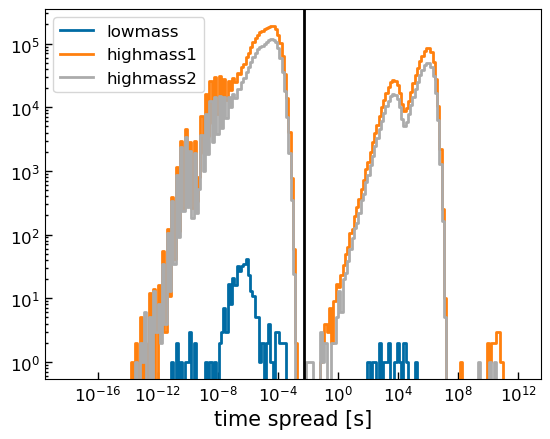

In [ ]:

plt.figure()

tbins = tdf['t'].values/1e9
for det in detectors:
    plt.step(tbins, tdf[det].values, label = det)

plt.legend()
plt.loglog()
plt.xlabel('time spread [s]')

idx = 105

plt.axvline(tbins[idx], color = 'k')

for det in detectors:
    R1 = sum(tdf[det].values[:idx])
    R2 = sum(tdf[det].values[idx:])
    print(det, R1, R2, R2/R1)
